### Machine Learning with Big Data
## Part 2: Convolutional Neural Networks

# 0.4 - CNN with Pooling

**Group:** MLBD_Deventer 4   
**Students:** Mathijs Pattipeilohy (512391), Emin Fikret (511275)

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

from joblib import load

2025-10-25 16:31:33.274688: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-25 16:31:33.282820: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-25 16:31:33.357038: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-25 16:31:34.739111: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
SEED = 42
EPOCHS = 10
BATCH  = 32 # default

tf.keras.utils.set_random_seed(SEED)

In [3]:
ARTIFACTS_DIR = "../artifacts"
MODEL_NAME = "cnn_pooling"

INPUT_FILE = os.path.join(ARTIFACTS_DIR, "images_tuple.joblib")

LOG_DIR   = os.path.join(ARTIFACTS_DIR, "logs", f"{MODEL_NAME}")
MODEL_FILE = os.path.join(ARTIFACTS_DIR, f"{MODEL_NAME}.keras")
CKPT_FILE  = os.path.join(ARTIFACTS_DIR, f"best_{MODEL_NAME}.keras")

In [4]:
(
    X_train, X_val, X_test,
    y_train, y_val, y_test,
    classes
) = load(INPUT_FILE)

num_classes = len(classes)
print("Classes:", classes)
print("Train shape:", X_train.shape, y_train.shape)

Classes: ['az', 'dobro', 'estb', 'frbtb', 'ize', 'jatb', 'ljudie', 'nasb', 'sa', 'sta', 'ukb', 'vede']
Train shape: (900, 128, 128, 4) (900, 12)


### Recap

In the previous iteration, we experimented with the number of filters and the padding type of the convolutional layers. 

The final model in the previous iteration is quite large, with more than 12 million parameters and a size of almost 50 MB, making it heavy and slower to train. It also shows slight overfitting on the validation data.

## Model: Pooling
To address the issues of the previous iteration, we add pooling layers after each convolutional layer. 

Pooling reduces the dimensionality of the convolutional output by summarizing nearby pixel values. 

This helps the model focus on the most important features instead of every small detail, which in turn reduces the number of parameters, decreases model size, and helps limit overfitting.

In [5]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=X_train.shape[1:]),
    tf.keras.layers.Rescaling(1.0 / 255), # min-max scale rbg values

    tf.keras.layers.Conv2D(
        32, (3,3), 
        activation="relu",
        padding="same", # add zeros around the edges
    ), # learns low-level features, like edges
    tf.keras.layers.MaxPooling2D((2,2)),
    
    tf.keras.layers.Conv2D(
        64, (3,3), 
        activation="relu",
        padding="same", # add zeros around the edges
    ), # learns higher-lever combinations, like shapes
    tf.keras.layers.MaxPooling2D((2,2)),
    
    tf.keras.layers.Flatten(), # turns 2d features into 1d vector
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(), # variation of gradient descent
    loss=tf.keras.losses.CategoricalCrossentropy(),
    # we could have just used accuracy, 
    # it would have fallen back to categorical accuracy
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │       786,444 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 806,124 (3.08 MB)

 Trainable params: 806,124 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

By adding a pooling layer after each convolutional layer, we reduced the number of parameters from about 12 million to 800 thousand, and the model size decreased almost 15 times.

In [6]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR),
    # Not included, because we cannot easily compare different models
    # if val_loss does not get better after 3 epochs, 
    # stop training and get the best model weights
    # tf.keras.callbacks.EarlyStopping(
    #     monitor="val_loss", patience=3, restore_best_weights=True
    # ),
    # save best model
    tf.keras.callbacks.ModelCheckpoint(
        CKPT_FILE, monitor="val_categorical_accuracy", save_best_only=True
    )
]

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH,
    shuffle=True,
    validation_data=(X_val, y_val),
    # or we could have used "validation_set" param
    callbacks=callbacks,
    verbose=2,
)

Epoch 1/10


2025-10-25 16:31:38.293303: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 235929600 exceeds 10% of free system memory.


29/29 - 11s - 370ms/step - categorical_accuracy: 0.6022 - loss: 1.5570 - val_categorical_accuracy: 0.8643 - val_loss: 0.5223
Epoch 2/10
29/29 - 10s - 339ms/step - categorical_accuracy: 0.9033 - loss: 0.2675 - val_categorical_accuracy: 0.8953 - val_loss: 0.3582
Epoch 3/10
29/29 - 11s - 364ms/step - categorical_accuracy: 0.9811 - loss: 0.0647 - val_categorical_accuracy: 0.9070 - val_loss: 0.3013
Epoch 4/10
29/29 - 17s - 573ms/step - categorical_accuracy: 0.9911 - loss: 0.0336 - val_categorical_accuracy: 0.8876 - val_loss: 0.3626
Epoch 5/10
29/29 - 17s - 589ms/step - categorical_accuracy: 0.9767 - loss: 0.0539 - val_categorical_accuracy: 0.9225 - val_loss: 0.2147
Epoch 6/10
29/29 - 11s - 380ms/step - categorical_accuracy: 0.9900 - loss: 0.0327 - val_categorical_accuracy: 0.9147 - val_loss: 0.2930
Epoch 7/10
29/29 - 10s - 331ms/step - categorical_accuracy: 0.9989 - loss: 0.0124 - val_categorical_accuracy: 0.9264 - val_loss: 0.2547
Epoch 8/10
29/29 - 11s - 375ms/step - categorical_accuracy:

Using pooling layers reduces the parameters and consequently the speed of the model. 

Base V3 has a speed of around 560-700/ms per step, and the current pooling version has around 210-270/ms per step. 

Pooling layers make the model lighter and faster.

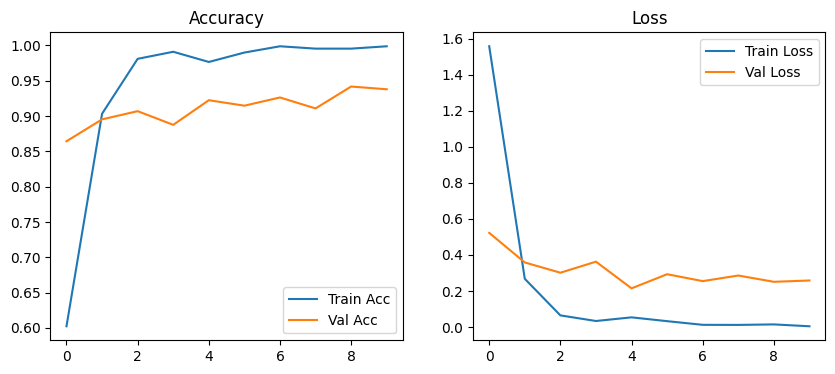

In [7]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['categorical_accuracy'], label='Train Acc')
plt.plot(history.history['val_categorical_accuracy'], label='Val Acc')
plt.title('Accuracy'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss'); plt.legend()

plt.show()

In [8]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - categorical_accuracy: 0.9000 - loss: 0.4134
Test accuracy: 0.9062


The test accuracy also increased slightly by 0.3 percent, showing that the model became more efficient without losing performance.

### Results: Pooling

Compared to the previous version, the accuracy curves fluctuated more throughout training but maintained a similar gap between training and validation accuracy as in version 3.

The loss gap increased slightly, showing a small bump around epoch 5, which suggests that the model briefly struggled to adapt before stabilizing again.

Although the accuracy and loss graphs do not look smoother than in the base model, the overall performance improved.

The model is significantly smaller, faster, and more efficient, and it even achieved a slightly higher accuracy, making this the preferred version so far.

-----

### Next steps

In the next iteration, we will experiment with dropout layers to explore what kind of results they bring and potentially further reduce overfitting.

-----

### References:
- https://www.geeksforgeeks.org/deep-learning/cnn-introduction-to-pooling-layer/
- https://www.youtube.com/watch?v=ZjM_XQa5s6s&list=PLZbbT5o_s2xq7LwI2y8_QtvuXZedL6tQU&index=23